In [1]:
from torch.utils.data import Dataset
import pydicom
import torchio
import numpy as np
import pandas as pd

import pickle
import os
import time

C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [2]:
target = 'Adjuvant Chemotherapy'

Load image data using PyTorch Dataset

In [3]:
class dcm_npy_loader(Dataset):

    def __init__(self, img_dir, load, shape=(512, 512)):
        self.img_dir = img_dir
        self.load = load
        self.shape = shape

        if not self.load:
            load_paths = list()
            for (dirpath, dirnames, filenames) in os.walk(img_dir):
                load_paths += [os.path.join(dirpath, file) for file in filenames]

            ids = np.array([], dtype=np.int8)
            img_list = []
            num_exceptions = 0
            for path in load_paths:
                try:
                    file = pydicom.dcmread(path)
                    if file.pixel_array.shape == self.shape:
                        id = file.PatientID
                        for c in id:
                            if not c.isdigit():
                                id = id.replace(c, '')

                        ids = np.append(ids, id)

                        subject_dict = {
                            'one image': torchio.ScalarImage(path),
                            'id':id,
                            'SliceLocation':file.SliceLocation
                        }
                        subject = torchio.Subject(subject_dict)

                        img_list.append(subject)
                except:
                    if num_exceptions < 5:
                        print("Image " + path + " could not be loaded")
                    elif num_exceptions == 5:
                        print("More than 5 exceptions occured")
                    
                    num_exceptions = num_exceptions + 1

            img_list.sort(key=lambda s: int(s['id']))

            ids = set([int(s['id']) for s in img_list])

            all_img3d = []
            all_ids = []
            all_sliceLocs = []
            for id in ids:
                prev_time_id = time.time()

                slices = []
                i = 0
                for slice in img_list:

                    p_id = int(slice['id'])

                    if int(p_id) == int(id):
                            
                        slices.append(slice)

                        # remove slices from dataset that have already been appended
                        del img_list[i]

                    i = i + 1

                id_slices = torchio.SubjectsDataset(slices)

                # ensure slices are in the correct order
                id_slices = sorted(id_slices, key=lambda s: s.SliceLocation)

                # create 3D array
                img_shape = list(id_slices[0]['one image']['data'].shape)
                img_shape.append(len(id_slices))
                img3d = np.empty(img_shape, dtype=np.int8)

                p_id = id_slices[0]['id']
                # get only numbers from patient id
                p_id = [int(s) for s in str(p_id) if s.isdigit()]
                p_id = int(''.join([str(i) for i in p_id]))

                slice_locs = []

                # fill 3D array with the images from the files
                for i, s in enumerate(id_slices):
                    img2d = s['one image']['data']

                    slice_locs.append(s['SliceLocation'])
                    if list(img2d.shape) == img_shape[:4]:
                        img3d[:, :, :, :, i] = img2d

                all_ids.append(p_id)
                img3d = np.squeeze(img3d)
                all_img3d.append(img3d)
                all_sliceLocs.append(slice_locs)

                aft_time_id = time.time()
                id_load_time = aft_time_id - prev_time_id

                print("id: " + str(id) + " has completed " + "in " + str(round(id_load_time,0)) + " seconds!")

            self.data = [all_img3d, all_ids, all_sliceLocs]

            with open('data\\Duke-Breast-Cancer-MRI\\data', 'wb') as fp:
                pickle.dump(self.data, fp)
        
        else:
            with open('data\\Duke-Breast-Cancer-MRI\\data', 'rb') as fp:
                self.data = pickle.load(fp)

    def __len__(self):
        return len(self.data[0])

    def __getitem__(self, idx):
        sample = [self.data[0][idx], self.data[1][idx], self.data[2][idx]]
        return sample

In [1]:
def import_numpy_2d(path, clinical_ids):
    ds = dcm_npy_loader(path, load=True)

    patients = []
    ids = []
    sliceLocs = []
    for sample in ds:
        patients.append(sample[0])
        ids.append(sample[1])
        sliceLocs.append(sample[2])

    i = 0
    for p in patients:
        p_id = ids[i]
        if not p_id in clinical_ids:
            del patients[i]

        i = i + 1

    slice_locations_min = []
    slice_locations_max = []
    for sl in sliceLocs:
        mi = np.amin(sl)
        ma = np.amax(sl)
        slice_locations_min.append(mi)
        slice_locations_max.append(ma)

    # number of intervals to collect for each patient
    interval_num = 100

    interval_nums = []
    all_intervals = []
    for ma, mi in zip(slice_locations_max, slice_locations_min):
        subinterval_length = int(round((ma-mi)/interval_num, 0))
        interval_nums.append(interval_num)

        interval_num = min(interval_nums)

        # set min slice loc as initial interval marker
        intervals = []
        interval_marker = mi
        for i in range(interval_num):
            intervals.append(interval_marker)
            interval_marker = interval_marker+subinterval_length*i

        all_intervals.append(intervals)

    # array to store all intervals
    all_interval_imgs = np.empty(shape=(len(ids), len(intervals), 512, 512), dtype=np.float16)

    # reshape all patients into (num_slices, res1, res2)
    new_patients = []
    for patient in patients:
        patient = np.reshape(patient, (patient.shape[-1], patient.shape[-2], patient.shape[-3]))
        new_patients.append(patient)

    patients = new_patients

    m = 0
    for p_id in ids:
        for i in range(len(intervals)):
            if i < (len(intervals)-1):
                low = intervals[i]
                high = intervals[i+1]

                interval_imgs = np.empty(shape=(len(intervals), 512, 512), dtype=np.float16)

                j = 0
                for p in patients:
                    id = ids[j]

                    k = 0
                    if int(id) == int(p_id):

                        for s in p:
                            slice_location=sliceLocs[j][k]

                            if slice_location < high and slice_location > low:
                                interval_imgs[i] = s

                                # break after adding one image from the interval
                                break

                            k = k + 1
                    
                    j = j + 1

        m = m + 1

    return all_interval_imgs, ids

Load clinical data

In [5]:
df = pd.read_csv('..\Clinical and Other Features.csv')

In [6]:
clinical_ids = df[list(df.columns)[0]]

In [7]:
img_array, image_ids = import_numpy_2d(None, clinical_ids)

Load image features

In [8]:
image_features = pd.read_csv('..\Imaging_Features.csv')

drop ids from image features to prevent duplicates

In [9]:
image_features = image_features.drop('Patient ID', axis=1)

In [10]:
df = pd.concat([df, image_features], axis=1)

In [11]:
df = df.set_index(str(list(df.columns)[0]))

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer

def tokenize_dataset(pd_dataset):

    # replace missing spots with a string then after dataset is encoded, replace with mean of column
    df = pd_dataset.fillna('empty')

    if df.shape[0] >= df.shape[1]:
        long_axis = df.shape[0]
        short_axis = df.shape[1]
    else:
        long_axis = df.shape[1]
        short_axis = df.shape[0]

    word_list = []
    for i in range(long_axis):
        for n in range(short_axis):
            
            if long_axis == df.shape[0]:
                data = df.iloc[i, n]
            else:
                data = df.iloc[n, i]

            if str(type(data)) == "<class 'str'>":

                # list of chars to be removed from data
                char_blocked = [' ', '.', '/', '-', '_', '>', '+', ',', ')', '(', '*',
                                '=', '?', ':', '[', ']', '#', '!', '\n', '\\', '}',
                                '{', ';', '%', '"']
                
                for char in char_blocked:
                    if char in data:
                        data = data.replace(char, '')

                data = data.lower()

                if long_axis == df.shape[0]:
                    df.iloc[i, n] = data
                else:
                    df.iloc[n, i] = data

                word_list.append(data)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(word_list)
    code_dict = tokenizer.word_index

    for i in range(long_axis):
        for n in range(short_axis):
            if long_axis == df.shape[0]:
                data = df.iloc[i, n]
            else: 
                data = df.iloc[n, i]

            if str(type(data)) == "<class 'str'>":
                
                data = int(code_dict[data])

            if long_axis == df.shape[0]: 
                df.iloc[i, n] = data
            else: 
                df.iloc[n, i] = data

    # replace spots previously denoted as 'empty' with mean of column
    for column in list(df.columns):
        col = df[column].copy()

        empty_indices = []

        i = 0
        for val in col:
            if val == code_dict['empty']:
                empty_indices.append(i)

            i = i + 1

        # get series labels at the empty indices for .drop function
        col_labels = list(col.index)

        empty_labels = []
        for index in empty_indices:
            empty_labels.append(col_labels[index])

        col_without_empty = col.drop(empty_labels)

        col_mean = col_without_empty.mean()

        i = 0
        for val in col:
            if val == code_dict['empty']:
                col[i] = col_mean

            i = i + 1
        
        df[column] = col

    # convert all cols to numeric vals
    df = df.astype('int64')

    return df

In [13]:
df = tokenize_dataset(df)

In [14]:
from sklearn.model_selection import train_test_split
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=84)
test_ids, val_ids = train_test_split(test_ids, test_size=0.5, random_state=84)

get patients in clinical data with ids that correspond with image ids

In [15]:
filtered_df = df.loc[image_ids]

In [16]:
clinical_x = filtered_df.drop(target, axis=1)

In [17]:
y = filtered_df[target]

In [18]:
x = [img_array, clinical_x]

In [19]:
X_train = []
X_test = []
X_val = []
for modality in x:
    i_X_train, i_X_test, y_train, y_test = train_test_split(modality, y, test_size=0.2, random_state=84)
    
    i_X_test, i_X_val = train_test_split(i_X_test, test_size=0.5, random_state=84)
    y_test, y_val = train_test_split(y_test, test_size=0.5, random_state=84)
    
    X_train.append(i_X_train)
    X_test.append(i_X_test)
    X_val.append(i_X_val)

normalize data

In [20]:
import tensorflow as tf
def four_dim_normalization(img_array):
    i = 0
    for p in img_array:
        s = tf.image.per_image_standardization(p)
        img_array[i] = s
        i = i + 1
        
    return img_array

In [21]:
X_train[0] = four_dim_normalization(X_train[0])
X_test[0] = four_dim_normalization(X_test[0])
X_val[0] = four_dim_normalization(X_val[0])

In [22]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
X_train[1] = min_max_scaler.fit_transform(X_train[1])
X_test[1] = min_max_scaler.fit_transform(X_test[1])
X_val[1] = min_max_scaler.fit_transform(X_val[1])

Use Isolation Forest to identify and remove outlier patients

In [23]:
from sklearn.ensemble import IsolationForest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def isolation_forest(features, target):

    isolated_forest=IsolationForest(n_estimators=2, n_jobs=-1, random_state=42) 
    if type(features) == tuple or type(features) == list:
        # concatenate features for image clinical
        clinical_array = features[0]
        image_array = features[1]

        new_array = np.empty(shape=(image_array.shape[0], int(image_array.shape[1])**2))
        i = 0
        for image in image_array:
            image = np.reshape(image, (1, int(image_array.shape[1])**2))
            new_array[i] = image

            i = i + 1
        
        image_array = new_array

        concatenated_array = np.concatenate((clinical_array, image_array), axis=1)
        
        isolated_forest.fit(concatenated_array, target)
        predicted = isolated_forest.predict(concatenated_array)
    else:
        isolated_forest.fit(features, target)
        predicted = isolated_forest.predict(features)

    predicted_df = pd.DataFrame(predicted)
    predicted_df.to_csv('data_anomaly.csv')

    outlier_indices = []
    i = 0
    for prediction in predicted:
        if prediction == -1:
            outlier_indices.append(i)

        i = i + 1

    pca = PCA(n_components=3)

    if type(features) == tuple or type(features) == list:
        features = concatenated_array

    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    features = pca.fit_transform(features)

    fig = plt.figure()
    fig.suptitle("3D PCA of Features with Outliers and Inliers")
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(features[:, 0], features[:, 1], zs=features[:, 2], s=4, lw=1, label="inliers", c="green")

    ax.scatter(features[outlier_indices,0], features[outlier_indices,1], features[outlier_indices,2], lw=2, s=60, marker='x', c='red', label='outliers')

    ax.legend()

    return predicted

In [24]:
def remove_outliers(X, y):
    predicted = isolation_forest(X, y)
    
    non_outlier_indices = []
    i = 0
    for prediction in predicted:
        if prediction != -1:
            non_outlier_indices.append(i)
        i = i + 1
        
    num_outliers = len(predicted) - len(non_outlier_indices)
    
    print('Num Outliers', num_outliers)
    
    X = X[non_outlier_indices]
    y = y.iloc[non_outlier_indices]
    
    return X, y

Num Outliers 4


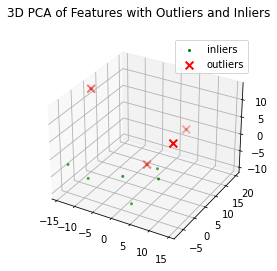

In [25]:
prev_indices = list(y_train.index)
X_train[1], y_train = remove_outliers(X_train[1], y_train)

removed_indices = []
j = 0
for i in prev_indices:
    if i not in list(y_train.index):
        removed_indices.append(j)
        
    j = j + 1

X_train[0] = np.delete(X_train[0], removed_indices, 0)

Apply random cropping

In [26]:
X_train[0] = tf.image.random_crop(X_train[0], (X_train[0].shape[0], X_train[0].shape[1], 256, 256))
X_test[0] = tf.image.random_crop(X_test[0], (X_test[0].shape[0], X_test[0].shape[1], 256, 256))
X_val[0] = tf.image.random_crop(X_val[0], (X_val[0].shape[0], X_val[0].shape[1], 256, 256))

Define model

In [27]:
def grey_to_rgb(img_array):
    width = img_array.shape[-3]
    height = img_array.shape[-2]
    new_img_array = np.empty((img_array.shape[0], img_array.shape[1], width, height, 3), dtype=np.uint8)
    i = 0
    for p in img_array:
        new_p = np.empty((p.shape[0], width, height, 3), dtype=np.float16)
        j = 0
        for s in p:
            s = np.squeeze(s)
            out = np.empty((width, height, 3), dtype=np.float16)
            out[:, :, 0] = s
            out[:, :, 1] = s
            out[:, :, 2] = s

            new_p[j] = out

            j = j + 1

        new_img_array[i] = new_p

        i = i + 1
    
    return new_img_array

In [28]:
import torch.nn as nn
from torch.autograd import Variable

class image_clinical(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.relu = nn.ReLU()
        self.clinical_track()
        self.image_track()
        
        self.fc1_cat = nn.Linear(415, 26)
        self.fc2_cat = nn.Linear(26, num_classes)
        
    def clinical_track(self):
        self.fc1 = nn.Linear(603, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, 15)

    def image_track(self):
        self.res = None
    
    def forward(self, data):
        image_data = data[0]
        clinical_data = data[1]
        
        # clinical
        clinical_x = self.relu(self.fc1(clinical_data))
        clinical_x = self.relu(self.fc2(clinical_x))
        clinical_x = self.relu(self.fc3(clinical_x))
        
        # image
        image_x = self.res(image_data)
        
        x = torch.cat([clinical_x, image_x], dim=1)
        
        x = self.relu(self.fc1_cat(x))
        x = self.fc2_cat(x)
        
        return x
    
    def train_func(self, config, data):
        id_X_train = data[0]
        id_y_train = data[1]
        self.res = data[2]
        X_train = ray.get(id_X_train)
        y_train = ray.get(id_y_train)
        epochs = config['epochs']
        batch_size = config['batch_size']
        lr = config['lr']
        self.criterion = torch.nn.CrossEntropyLoss()
        for epoch in range(int(epochs)):
            running_loss = 0.0
            for i in range((X_train[1].shape[0]-1)//batch_size + 1):

                start_i = i*batch_size
                end_i = start_i+batch_size

                xb = [X_train[0][start_i:end_i], X_train[1][start_i:end_i]]

                yb = y_train[start_i:end_i]
                print(type(yb))
                yb = Variable(yb)

                xb[0] = torch.unsqueeze(xb[0].type(torch.float), -1)
                xb[0] = grey_to_rgb(xb[0])/255
                # reshape to have 3 channels
                xb[0] = np.reshape(xb[0], (xb[0].shape[0], xb[0].shape[-1], xb[0].shape[1], xb[0].shape[2], xb[0].shape[3]))
                xb[0] = torch.from_numpy(xb[0]).type(torch.float)
                xb[1] = xb[1].type(torch.float)
                pred = self(xb)

                optimizer = torch.optim.Adam(self.parameters(), lr=lr)

                loss = self.criterion(pred, yb)
        
                loss.backward()
                optimizer.step()

                # zero the parameter gradients
                optimizer.zero_grad()

                # print stats
                running_loss += loss.item()
                pred = pred.detach()
                self.loss = running_loss
                pred = np.argmax(pred, axis=1)
                self.accuracy = accuracy_score(yb, pred)
                self.f1_score = f1_m(yb, pred)
                self.recall = recall_m(yb, pred)
                self.balanced_acc = balanced_accuracy_score(yb, pred)
                if i % 2000 == 1999: # print every 2000 mini-batches
                    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}', 'Accuracy: %.4f' %self.accuracy, 'F1: %.4f' %self.f1_score, 'Recall: %.4f' %self.recall, 'Balanced Accuracy: %.4f' %self.balanced_acc)
                tune.report(loss=running_loss, accuracy=self.accuracy)
                running_loss = 0.0

        print("Finished Training")

In [29]:
import torchvision.models as models
from ray.tune.schedulers.async_hyperband import ASHAScheduler
import ray
from ray import tune

class image_model:

    def __init__(self, load_model=True):
        self.load_model = load_model
        self.res = models.video.r3d_18(pretrained=False)

    def main(self, X_train, y_train, num_samples=10, max_num_epochs=10, gpus_per_trial=2):
        # get number of classes in y
        y = []
        for i in y_train:
            i = int(i)
            y.append(i)
        
        y = list(set(y))
        num_classes = len(y)

        # make classes start from 0
        class_dict = dict()
        for i in range(num_classes):
            class_dict[y[i]] = i

        i = 0
        for val in y_train:
            new_val = class_dict[int(val)]
            y_train[i] = new_val
            i = i + 1

        if len(y_train.shape) > 1:
            self.multi_target = True
        else:
            self.multi_target = False
            
        id_X_train = ray.put(X_train)
        id_y_train = ray.put(y_train)

        self.model = image_clinical(num_classes)

        config = {
            'epochs':tune.choice([50, 100, 150]),
            'batch_size':tune.choice([8, 16, 20]),
            'lr':tune.loguniform(1e-4, 1e-1)
        }      
        scheduler = ASHAScheduler(
            max_t=max_num_epochs,
            grace_period=1,
            reduction_factor=3)
        if torch.cuda.is_available():
            result = tune.run(
                tune.with_parameters(self.model.train_func, data=[id_X_train, id_y_train, self.res]),
                resources_per_trial={"cpu":4, "gpu":gpus_per_trial},
                config=config,
                metric="accuracy",
                mode="min",
                num_samples=num_samples,
                scheduler=scheduler
            )
        else:
            result = tune.run(
                tune.with_parameters(self.model.train_func, data=[id_X_train, id_y_train, self.res]),
                resources_per_trial={"cpu":4},
                config=config,
                metric="accuracy",
                mode="min",
                num_samples=num_samples,
                scheduler=scheduler
            )

        best_trial = result.get_best_trial("loss", "min", "last")
        print("Best trial config: {}".format(best_trial.config))
        print("Best trial final validation loss: {}".format(
            best_trial.last_result["loss"]))
        print("Best trial final validation accuracy: {}".format(
            best_trial.last_result['accuracy']))

        self.model.train_func(config=best_trial.config, data=[id_X_train, id_y_train, self.res])

        torch.save(self.model.state_dict(), "torch_image_clinical_model.pth")

        return self.model

    def test_model(self, X_test, y_test):
        X_test = [torch.from_numpy(np.array(X_test[0])).type(torch.float), torch.from_numpy(np.array(X_test[1])).type(torch.float)]
        X_test[0] = torch.unsqueeze(X_test[0], -1)
        X_test[0] = grey_to_rgb(X_test[0])/255
        # reshape to have 3 channels
        X_test[0] = np.reshape(X_test[0], (X_test[0].shape[0], X_test[0].shape[-1], X_test[0].shape[1], X_test[0].shape[2], X_test[0].shape[3]))
        i = 0
        for arr in X_test:
            if type(arr) == np.ndarray:
                arr = torch.from_numpy(arr).type(torch.float)
                X_test[i] = arr
            i = i + 1
        self.criterion = torch.nn.CrossEntropyLoss()
        y_test = torch.from_numpy(np.array(y_test)).type(torch.float)
        with torch.no_grad():
            y_pred = self.model(X_test)
            confusion_matrix(y_test, y_pred, save_name="image_only_c_mat_torch")
            test_loss = self.criterion(y_pred, y_test)
            accuracy = accuracy_score(y_test, y_pred)
            f1_score = f1_m(y_test, y_pred)
            recall = recall_m(y_test, y_pred)
            balanced_acc = balanced_accuracy_score(y_test, y_pred)

        return test_loss, accuracy, f1_score, recall, balanced_acc

    def get_model(self, X_train=None, y_train=None, X_val=None, y_val=None, epochs=10, batch_size=128):
        
        if self.load_model:
            self.model = image_clinical()
            self.model.res = self.res
            self.model.load_state_dict(torch.load("torch_image_clinical_model.pth"), strict=False)
        else:
            self.model = self.main(X_train, y_train)

        return self.model

In [30]:
model = image_model(load_model=False)

In [31]:
import torch

i = 0
for train, val in zip(X_train, X_val):
    train = torch.from_numpy(np.array(train))
    val = torch.from_numpy(np.array(val))
    
    X_train[i] = train
    X_val[i] = val
    
    i = i + 1
    
y_train = torch.from_numpy(np.array(y_train))
y_val = torch.from_numpy(np.array(y_val))

In [32]:
model.get_model(X_train, y_train, X_val, y_val)

torch.Size([6, 100, 256, 256])
torch.Size([6, 603])


2022-07-09 12:46:15,197	WARNING function_runner.py:598 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-07-09 12:46:15,581	INFO trial_runner.py:803 -- starting train_func_0787e_00000
2022-07-09 12:46:15,693	ERROR syncer.py:119 -- Log sync requires rsync to be installed.
(pid=) C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
(pid=)   warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
(pid=) C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a s

Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,PENDING,,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


2022-07-09 12:46:19,860	INFO trial_runner.py:803 -- starting train_func_0787e_00001


(train_func pid=14900) <class 'torch.Tensor'>


(pid=) C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
(pid=)   warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
(pid=) C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
(pid=)   warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


(train_func pid=22024) <class 'torch.Tensor'>


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00001,RUNNING,127.0.0.1:22024,20,150,0.000117863
train_func_0787e_00002,PENDING,,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822


(train_func pid=22024) 2022-07-09 12:47:16,693	ERROR function_runner.py:281 -- Runner Thread raised error.
(train_func pid=22024) Traceback (most recent call last):
(train_func pid=22024)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\tune\function_runner.py", line 272, in run
(train_func pid=22024)     self._entrypoint()
(train_func pid=22024)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\tune\function_runner.py", line 348, in entrypoint
(train_func pid=22024)     return self._trainable_func(
(train_func pid=22024)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\util\tracing\tracing_helper.py", line 462, in _resume_span
(train_func pid=22024)     return method(self, *_args, **_kwargs)
(train_func pid=22024)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\tune\function_runner.py", line 640, in _trainable_func
(train_func pid=22024)  

2022-07-09 12:47:19,610	ERROR trial_runner.py:876 -- Trial train_func_0787e_00001: Error processing event.
NoneType: None


Result for train_func_0787e_00001:
  date: 2022-07-09_12-46-24
  experiment_id: 0cc7d376c3af484c883fd0fcf8e64488
  hostname: Tristens-PC
  node_ip: 127.0.0.1
  pid: 22024
  timestamp: 1657388784
  trial_id: 0787e_00001
  


2022-07-09 12:47:20,072	INFO trial_runner.py:803 -- starting train_func_0787e_00002
(pid=) 2022-07-09 12:47:20,042	INFO context.py:67 -- Exec'ing worker with command: "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\python.exe" C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\workers/default_worker.py --node-ip-address=127.0.0.1 --node-manager-port=63550 --object-store-name=tcp://127.0.0.1:64744 --raylet-name=tcp://127.0.0.1:64150 --redis-address=None --storage=None --temp-dir=C:\Users\trist\AppData\Local\Temp\ray --metrics-agent-port=63803 --logging-rotate-bytes=536870912 --logging-rotate-backup-count=5 --gcs-address=127.0.0.1:63629 --redis-password=5241590000000000 --startup-token=9 --runtime-env-hash=-125176900
(pid=) C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.6) doesn't match a supported version!
(pid=) 

Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00002,RUNNING,127.0.0.1:2980,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822
train_func_0787e_00001,ERROR,127.0.0.1:22024,20,150,0.000117863


(train_func pid=2980) <class 'torch.Tensor'>


2022-07-09 12:47:29,101	WARNING tune.py:650 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00002,RUNNING,127.0.0.1:2980,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822
train_func_0787e_00001,ERROR,127.0.0.1:22024,20,150,0.000117863


Trial name,status,loc,batch_size,epochs,lr
train_func_0787e_00000,RUNNING,127.0.0.1:14900,8,50,0.00755458
train_func_0787e_00002,RUNNING,127.0.0.1:2980,20,100,0.000438003
train_func_0787e_00003,PENDING,,8,100,0.0303044
train_func_0787e_00004,PENDING,,20,150,0.000203301
train_func_0787e_00005,PENDING,,20,150,0.00173267
train_func_0787e_00006,PENDING,,20,100,0.000246187
train_func_0787e_00007,PENDING,,8,100,0.0772869
train_func_0787e_00008,PENDING,,8,50,0.000393541
train_func_0787e_00009,PENDING,,8,100,0.00309822
train_func_0787e_00001,ERROR,127.0.0.1:22024,20,150,0.000117863


(train_func pid=2980) 2022-07-09 12:48:14,710	ERROR function_runner.py:281 -- Runner Thread raised error.
(train_func pid=2980) Traceback (most recent call last):
(train_func pid=2980)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\tune\function_runner.py", line 272, in run
(train_func pid=2980)     self._entrypoint()
(train_func pid=2980)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\tune\function_runner.py", line 348, in entrypoint
(train_func pid=2980)     return self._trainable_func(
(train_func pid=2980)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\util\tracing\tracing_helper.py", line 462, in _resume_span
(train_func pid=2980)     return method(self, *_args, **_kwargs)
(train_func pid=2980)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\ray\tune\function_runner.py", line 640, in _trainable_func
(train_func pid=2980)     output 

(train_func pid=2980)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\torch\nn\modules\module.py", line 1051, in _call_impl
(train_func pid=2980)     return forward_call(*input, **kwargs)
(train_func pid=2980)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\torch\nn\modules\conv.py", line 587, in forward
(train_func pid=2980)     return self._conv_forward(input, self.weight, self.bias)
(train_func pid=2980)   File "C:\Users\trist\cs_projects\Cancer_Project\Cancer_ML\env\lib\site-packages\torch\nn\modules\conv.py", line 582, in _conv_forward
(train_func pid=2980)     return F.conv3d(
(train_func pid=2980) RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:79] data. DefaultCPUAllocator: not enough memory: you tried to allocate 2516582400 bytes.


KeyboardInterrupt: 

In [ ]:
model.test_model(X_test, y_test)